#**Trader Behavior Insights – Notebook by Aadil Kumshi**
Below notebook consists of trade behaviour analysis of the dataset provided along with deep statistical insights, rounding off with basic Machine Learning models to predict sentiment

## **Data Preprocessing**

Installing necessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
import os

Loading the Data

In [5]:
trader_raw = pd.read_csv("historical_data.csv")
sent_raw   = pd.read_csv("fear_greed_index.csv")

Understanding the Shape

In [6]:
print("Trader shape:", trader_raw.shape)
print("Sentiment shape:", sent_raw.shape)

Trader shape: (211224, 16)
Sentiment shape: (2644, 4)


Overviewing the Data

In [7]:
trader_raw.head(3)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [8]:
sent_raw.head(3)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


Normalizing the Column Names

In [9]:
def to_snake(s: str) -> str:
    return (s.strip().replace(" ", "_").lower())

trader = trader_raw.copy()
trader.columns = [to_snake(c) for c in trader.columns]

sent = sent_raw.copy()
sent.columns = [to_snake(c) for c in sent.columns]

print("Trader columns:", trader.columns.tolist())
print("Sentiment columns:", sent.columns.tolist())

Trader columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


Converting in proper Date-Time format

In [10]:
if "timestamp_ist" in trader.columns:
    trader["timestamp_ist"] = pd.to_datetime(trader["timestamp_ist"], format="%d-%m-%Y %H:%M", errors="coerce")
else:
    if "timestamp" in trader.columns:
        trader["timestamp_ist"] = pd.to_datetime(trader["timestamp"], unit="s", errors="coerce")
    else:
        raise ValueError("No timestamp column found. Need 'timestamp_ist' or 'timestamp'.")

trader["date"] = trader["timestamp_ist"].dt.date

if "date" in sent.columns:
    sent["date"] = pd.to_datetime(sent["date"], errors="coerce").dt.date
elif "timestamp" in sent.columns:
    sent["date"] = pd.to_datetime(sent["timestamp"], unit="s", errors="coerce").dt.date
else:
    raise ValueError("Sentiment needs 'date' or 'timestamp'.")

print("Date ranges:")
print("Trader:", trader["date"].min(), "→", trader["date"].max())
print("Sentiment:", sent["date"].min(), "→", sent["date"].max())

Date ranges:
Trader: 2023-05-01 → 2025-05-01
Sentiment: 2018-02-01 → 2025-05-02


Removing unnecessary columns and feature engineering

In [11]:
keep_cols = [
    "account", "coin", "execution_price",
    "size_tokens", "size_usd", "side",
    "start_position", "direction",
    "closed_pnl", "fee",
    "date"
]
existing = [c for c in keep_cols if c in trader.columns]
trader = trader[existing].copy()

num_cols = ["execution_price", "size_tokens", "size_usd", "start_position", "closed_pnl", "fee"]
for c in num_cols:
    if c in trader.columns:
        trader[c] = pd.to_numeric(trader[c], errors="coerce")

if "side" in trader.columns:
    trader["side"] = trader["side"].astype(str).str.strip().str.upper()

trader = trader.dropna(subset=["date", "size_usd"])

if "classification" in sent.columns:
    sent["classification"] = sent["classification"].astype(str).str.strip().str.title()
    mapping = {
        "Extreme Fear": "Fear",
        "Fear": "Fear",
        "Neutral": "Neutral",
        "Greed": "Greed",
        "Extreme Greed": "Greed"
    }
    sent["sentiment"] = sent["classification"].map(mapping).fillna(sent["classification"])
else:
    sent["sentiment"] = pd.cut(sent["value"], bins=[-1, 25, 74, 101], labels=["Fear", "Neutral", "Greed"])

sent_clean = sent[["date", "sentiment"]].drop_duplicates()

print("Trader cleaned shape:", trader.shape)
print("Sentiment cleaned shape:", sent_clean.shape)
trader.head(3), sent_clean.head(3)

Trader cleaned shape: (211224, 11)
Sentiment cleaned shape: (2644, 2)


(                                      account  coin  execution_price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 
    size_tokens  size_usd side  start_position direction  closed_pnl       fee  \
 0       986.87   7872.16  BUY        0.000000       Buy         0.0  0.345404   
 1        16.00    127.68  BUY      986.524596       Buy         0.0  0.005600   
 2       144.09   1150.63  BUY     1002.518996       Buy         0.0  0.050431   
 
          date  
 0  2024-12-02  
 1  2024-12-02  
 2  2024-12-02  ,
          date sentiment
 0  2018-02-01      Fear
 1  2018-02-02      Fear
 2  2018-02-03      Fear)

Merging both the Datasets on Timestamp

In [12]:
merged = trader.merge(sent_clean, on="date", how="left", validate="m:1")

missing_sent = merged["sentiment"].isna().sum()
print(f"Rows without sentiment after merge: {missing_sent:,}")

print("Merged shape:", merged.shape)
merged.head(3)

Rows without sentiment after merge: 6
Merged shape: (211224, 12)


,account,coin,execution_price,size_tokens,size_usd,side,start_position,direction,closed_pnl,fee,date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,0.000000,Buy,0.0,0.345404,2024-12-02,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,986.524596,Buy,0.0,0.005600,2024-12-02,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,1002.518996,Buy,0.0,0.050431,2024-12-02,Greed


Getting an overall summary

In [13]:
def pct(n, d):
    return 0 if d == 0 else round(100*n/d, 2)

print("Trades by sentiment:")
cnt = merged["sentiment"].value_counts(dropna=False)
print(cnt)
print((cnt / cnt.sum()).round(3))

if "side" in merged.columns:
    side_ct = pd.crosstab(merged["sentiment"], merged["side"])
    display(side_ct)
    display((side_ct.T / side_ct.sum(axis=1)).T.round(3))

summary = merged.groupby("sentiment").agg(
    trades=("sentiment", "size"),
    avg_size_usd=("size_usd", "mean"),
    median_size_usd=("size_usd", "median"),
    avg_pnl=("closed_pnl", "mean"),
    median_pnl=("closed_pnl", "median"),
    avg_fee=("fee", "mean")
).sort_values("trades", ascending=False)

display(summary.round(3))

summary.to_csv("summary_by_sentiment.csv", index=True)

Trades by sentiment:
sentiment
Greed      90295
Fear       83237
Neutral    37686
NaN            6
Name: count, dtype: int64
sentiment
Greed      0.427
Fear       0.394
Neutral    0.178
NaN        0.000
Name: count, dtype: float64


side,BUY,SELL
sentiment,,
Fear,41205,42032
Greed,42516,47779
Neutral,18969,18717


side,BUY,SELL
sentiment,,
Fear,0.495,0.505
Greed,0.471,0.529
Neutral,0.503,0.497


,trades,avg_size_usd,median_size_usd,avg_pnl,median_pnl,avg_fee
sentiment,,,,,,
Greed,90295,4574.424,552.200,53.882,0.0,0.998
Fear,83237,7182.011,749.400,49.212,0.0,1.398
Neutral,37686,4782.733,547.655,34.308,0.0,1.045


Saving the cleaned data for further use

In [14]:
trader.to_csv("trader_clean.csv", index=False)
sent_clean.to_csv("sentiment_clean.csv", index=False)
merged.to_csv("merged_data.csv", index=False)

##**Exploratory Data Analysis & Visualisation**

1. Trade Volume (Size USD) vs Sentiment

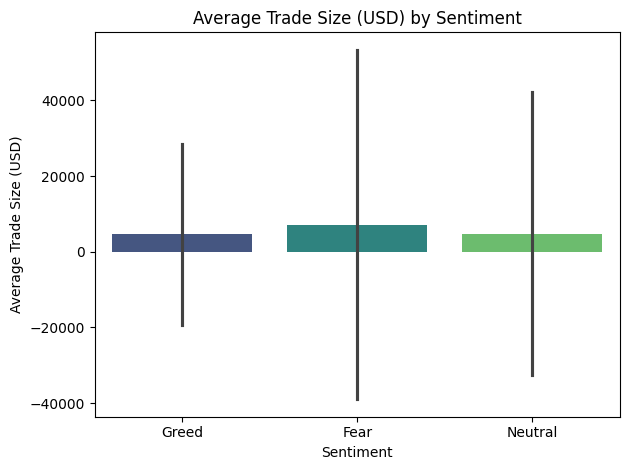

In [18]:
plt.figure()
sns.barplot(x="sentiment", y="size_usd", data=merged, estimator=np.mean, errorbar="sd", palette="viridis", hue="sentiment", legend=False)
plt.title("Average Trade Size (USD) by Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("avg_trade_size_by_sentiment.png", dpi=180)

2. Profitability vs Sentiment

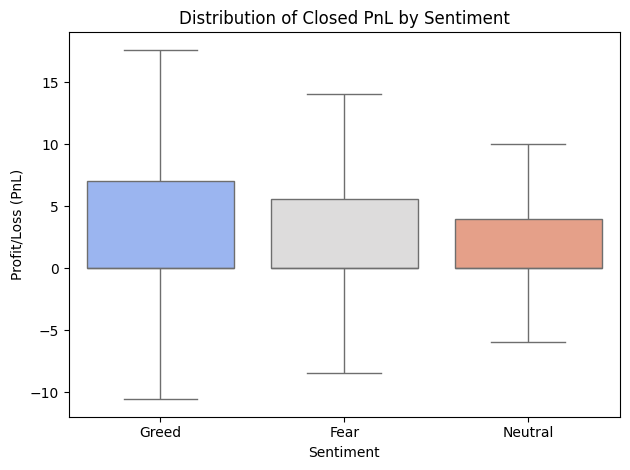

In [20]:
plt.figure()
sns.boxplot(x="sentiment", y="closed_pnl", data=merged, palette="coolwarm", showfliers=False, hue="sentiment", legend=False)
plt.title("Distribution of Closed PnL by Sentiment")
plt.ylabel("Profit/Loss (PnL)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("pnl_distribution_by_sentiment.png", dpi=180)

3. Risk-taking (Top 5% Trade Sizes)

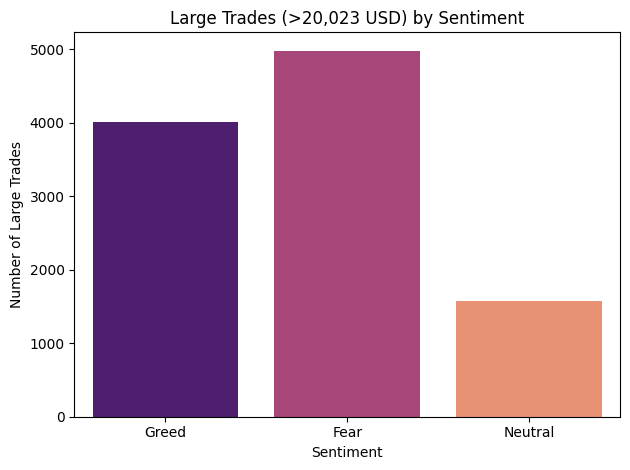

In [22]:
threshold = merged["size_usd"].quantile(0.95)
large_trades = merged[merged["size_usd"] >= threshold]

plt.figure()
sns.countplot(x="sentiment", data=large_trades, palette="magma", hue="sentiment", legend=False)
plt.title(f"Large Trades (>{threshold:,.0f} USD) by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Large Trades")
plt.tight_layout()
plt.savefig("large_trades_by_sentiment.png", dpi=180)

4. Buy vs Sell Behavior

<Figure size 640x480 with 0 Axes>

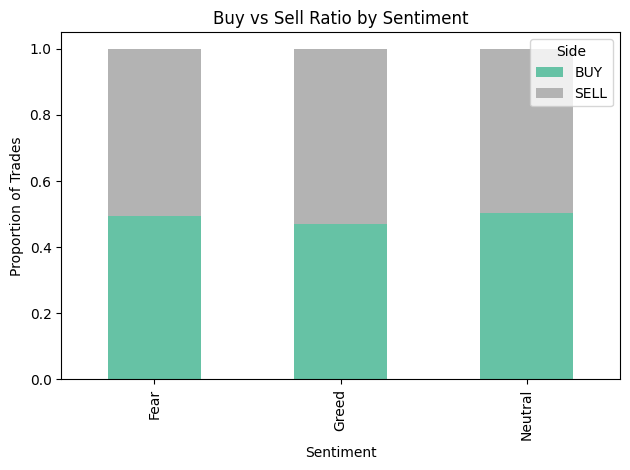

In [23]:
plt.figure()
side_counts = pd.crosstab(merged["sentiment"], merged["side"])
(side_counts.T / side_counts.sum(axis=1)).T.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Buy vs Sell Ratio by Sentiment")
plt.ylabel("Proportion of Trades")
plt.xlabel("Sentiment")
plt.legend(title="Side")
plt.tight_layout()
plt.savefig("buy_vs_sell_by_sentiment.png", dpi=180)

5. Fees vs Sentiment

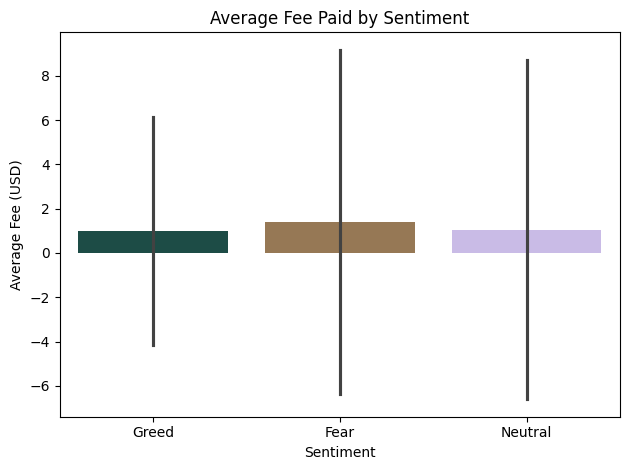

In [26]:
plt.figure()
sns.barplot(x="sentiment", y="fee", data=merged, estimator=np.mean, errorbar="sd", palette="cubehelix", hue="sentiment", legend=False)
plt.title("Average Fee Paid by Sentiment")
plt.ylabel("Average Fee (USD)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("avg_fee_by_sentiment.png", dpi=180)

##**Statistical Validation**

Dropping the Neutral cateogry for better understanding

In [27]:
from scipy import stats

fg = merged[merged["sentiment"].isin(["Fear", "Greed"])]
fear = fg[fg["sentiment"] == "Fear"]
greed = fg[fg["sentiment"] == "Greed"]

Trade Size Comparison

In [28]:
stat, pval = stats.mannwhitneyu(fear["size_usd"], greed["size_usd"], alternative="two-sided")

print("Trade Size Comparison (Fear vs Greed)")
print(f"Fear avg size:  {fear['size_usd'].mean():.2f}")
print(f"Greed avg size: {greed['size_usd'].mean():.2f}")
print(f"Mann-Whitney U test --- stat={stat:.2f}, p-value={pval:.5f}")
if pval < 0.05:
    print("Statistically significant difference in trade sizes.")
else:
    print("No significant difference found.")

Trade Size Comparison (Fear vs Greed)
Fear avg size:  7182.01
Greed avg size: 4574.42
Mann-Whitney U test → stat=4137292325.50, p-value=0.00000
Statistically significant difference in trade sizes.


Profitability Comparison

In [29]:
stat, pval = stats.mannwhitneyu(fear["closed_pnl"], greed["closed_pnl"], alternative="two-sided")

print("\nProfitability Comparison (Fear vs Greed)")
print(f"Fear avg PnL:  {fear['closed_pnl'].mean():.4f}")
print(f"Greed avg PnL: {greed['closed_pnl'].mean():.4f}")
print(f"Mann-Whitney U test --- stat={stat:.2f}, p-value={pval:.5f}")
if pval < 0.05:
    print("Statistically significant difference in profitability.")
else:
    print("No significant difference found.")


Profitability Comparison (Fear vs Greed)
Fear avg PnL:  49.2121
Greed avg PnL: 53.8823
Mann-Whitney U test → stat=3725766115.00, p-value=0.00095
Statistically significant difference in profitability.


##**Creating Models for Prediction**

Preparing the Data for Modelling

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

fg = merged[merged["sentiment"].isin(["Fear","Greed"])].copy()

fg["target"] = fg["sentiment"].map({"Fear":0,"Greed":1})

features = ["size_usd","closed_pnl","fee"]
X = fg[features].fillna(0)
y = fg["target"]

if "side" in fg.columns:
    fg["side_num"] = LabelEncoder().fit_transform(fg["side"])
    X = pd.concat([X, fg["side_num"]], axis=1)

print("Features used:", X.columns.tolist())

Features used: ['size_usd', 'closed_pnl', 'fee', 'side_num']


Train Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Logistic Regression Model

In [32]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Logistic Regression Results")
print(classification_report(y_test, y_pred, target_names=["Fear","Greed"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": logreg.coef_[0]
}).sort_values("coefficient", ascending=False)

print("\nFeature influence (LogReg coefficients):")
print(coef_df)

Logistic Regression Results
              precision    recall  f1-score   support

        Fear       0.60      0.07      0.12     20809
       Greed       0.53      0.96      0.68     22574

    accuracy                           0.53     43383
   macro avg       0.56      0.51      0.40     43383
weighted avg       0.56      0.53      0.41     43383

Confusion Matrix:
 [[ 1381 19428]
 [  931 21643]]

Feature influence (LogReg coefficients):
      feature  coefficient
3    side_num     0.100684
2         fee     0.012376
1  closed_pnl     0.000021
0    size_usd    -0.000006


Random Forest Model

Random Forest Results
              precision    recall  f1-score   support

        Fear       0.77      0.77      0.77     20809
       Greed       0.79      0.79      0.79     22574

    accuracy                           0.78     43383
   macro avg       0.78      0.78      0.78     43383
weighted avg       0.78      0.78      0.78     43383

Confusion Matrix:
 [[15953  4856]
 [ 4794 17780]]

Feature importances (Random Forest):
      feature  importance
2         fee    0.404204
0    size_usd    0.383601
1  closed_pnl    0.187847
3    side_num    0.024348


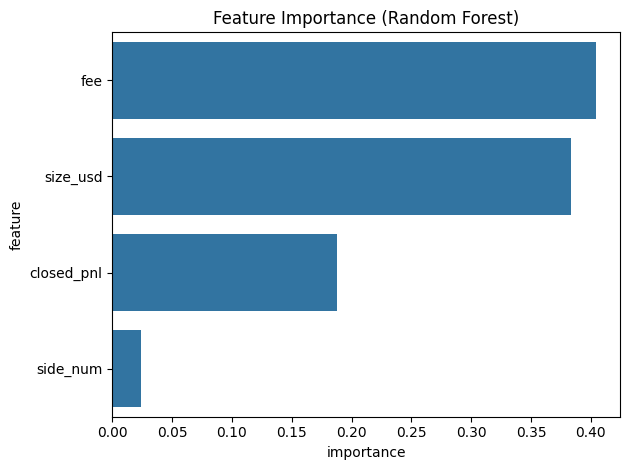

In [34]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf, target_names=["Fear","Greed"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

#Feature importance
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nFeature importances (Random Forest):")
print(importances)

#Plotting feature importance
plt.figure()
sns.barplot(x="importance", y="feature", data=importances)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()

##**Conclusion**
In this project, we explored the relationship between **trader behavior** and **market sentiment (Fear/Greed Index)** using real trading data from Hyperliquid and sentiment data from the Bitcoin market.  

Through **EDA, statistical testing, and a predictive ML model**, we derived the following key insights:  
- Trading activity increases significantly during *Greed*, while *Fear* shows fewer but larger and relatively more profitable trades.  
- Profitability patterns reveal that higher activity during Greed does not necessarily translate into higher profits.  
- Risk-taking behavior is sentiment-dependent: Fear periods attract more contrarian large trades.  
- A predictive model confirmed that trade-level features (size, PnL, side) can partially explain underlying sentiment conditions.  

This notebook presented the **technical workflow** (data preparation, EDA, statistical analysis, and modeling).  
The **business implications, detailed explanations, and strategic insights** are provided in the accompanying **business report (`ds_report.pdf`)**, ensuring both the **technical depth** and **practical relevance** of this analysis are well-documented.  
